In [2]:
pip install geneticalgorithm

     ---------------------------------------- 44.3/44.3 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15081 sha256=46720d68430e1c94d836c62eadfd024b1dcf7e2c4f860007525005b252a45cae
  Stored in directory: c:\users\lpate\appdata\local\pip\cache\wheels\ef\91\3f\17cbea1e83d17cc01bd2d66a0d59e65301bcb2d59f2f6a62ab
Successfully built func-timeout
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import wrds
import scipy.stats as st
import statsmodels.api as sm
import zipfile
import math
from geneticalgorithm import geneticalgorithm as ga

In [4]:
folder = 'C:\\Users\\lpate\\Documents\\ASAM\\ASAM_2024_Team1\\'

# Data Load & Cleaning

In [ ]:
crspRaw = pd.read_csv(folder + 'crsp_raw.zip',compression='zip')

In [3]:
crspRaw['date'] = pd.to_datetime(crspRaw['date'], format='%Y-%m-%d')
crspRaw['PERMNO'] = crspRaw['PERMNO'].astype(int)
crspRaw['PRC']=pd.to_numeric(crspRaw['PRC'], errors='coerce')
crspRaw['abs_PRC']=crspRaw['PRC'].abs()
crspRaw['SHROUT']=pd.to_numeric(crspRaw['SHROUT'], errors='coerce')
crspRaw['RET']=pd.to_numeric(crspRaw['RET'], errors='coerce')
crspRaw['SHRCD']=pd.to_numeric(crspRaw['SHRCD'], errors='coerce')
crspRaw['EXCHCD']=pd.to_numeric(crspRaw['EXCHCD'], errors='coerce')

crspRaw.dropna(axis=0, inplace=True)
crspRaw.sort_values(by=['PERMNO', 'date'], ascending=False, inplace=True)
crspRaw.reset_index(drop=True, inplace=True)

crspRaw['year']=crspRaw['date'].dt.year
crspRaw['quarter']=crspRaw['date'].dt.quarter
#does Market cap use prc or prc.abs()
crspRaw['marketCap']=crspRaw['PRC'] * crspRaw['SHROUT']

In [4]:
crspRaw

,PERMNO,date,SHRCD,EXCHCD,TICKER,COMNAM,PRC,RET,SHROUT,abs_PRC,year,quarter,marketCap
0,93436,2022-12-30,11.0,3.0,TSLA,TESLA INC,123.1800,0.011164,3157752.0,123.1800,2022,4,3.889719e+08
1,93436,2022-12-29,11.0,3.0,TSLA,TESLA INC,121.8200,0.080827,3157752.0,121.8200,2022,4,3.846773e+08
2,93436,2022-12-28,11.0,3.0,TSLA,TESLA INC,112.7100,0.033089,3157752.0,112.7100,2022,4,3.559102e+08
3,93436,2022-12-27,11.0,3.0,TSLA,TESLA INC,109.1000,-0.114089,3157752.0,109.1000,2022,4,3.445107e+08
4,93436,2022-12-23,11.0,3.0,TSLA,TESLA INC,123.1500,-0.017551,3157752.0,123.1500,2022,4,3.888772e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41925563,10001,2000-01-07,11.0,3.0,EWST,ENERGY WEST INC,8.4375,-0.007353,2450.0,8.4375,2000,1,2.067188e+04
41925564,10001,2000-01-06,11.0,3.0,EWST,ENERGY WEST INC,8.5000,-0.007299,2450.0,8.5000,2000,1,2.082500e+04
41925565,10001,2000-01-05,11.0,3.0,EWST,ENERGY WEST INC,8.5625,0.014815,2450.0,8.5625,2000,1,2.097812e+04
41925566,10001,2000-01-04,11.0,3.0,EWST,ENERGY WEST INC,8.4375,-0.014599,2450.0,8.4375,2000,1,2.067188e+04


In [5]:
#Remove rows where SHRCD is not 10 or 11
crspRaw = crspRaw[(crspRaw['SHRCD'] == 11.0) | (crspRaw['SHRCD'] == 10.0)]

#Remove rows where EXCHCD is not 1, 2, or 3
crspRaw = crspRaw[(crspRaw['EXCHCD'] == 1.0) | (crspRaw['EXCHCD'] == 2.0) | (crspRaw['EXCHCD'] == 3.0)]

In [7]:
crspRaw.to_pickle(folder + 'cleanCrsp.pkl')

# Eligible Universe

In [28]:
univ = pd.read_pickle(folder + 'cleanCrsp.pkl')

In [29]:
#Drop stocks that did not trade at least $100K on 200 days each year
univ['nTradingDays'] = univ.groupby(['PERMNO','year'])['RET'].transform('count')
#market cap greater than 100k?
univ = univ[(univ['nTradingDays']>=200) & (univ['marketCap']>=100000)]

In [30]:
#Drop stocks that were not active on the last day of the year
lastDate = univ.groupby(['year'])['date'].max()
yearReturns = univ.copy()
yearReturns = yearReturns[yearReturns['date'].isin(lastDate.values)]
yearReturns = yearReturns.sort_values(by = ['date','PERMNO']).reset_index(drop=True)

mergedReturns = pd.merge(univ, yearReturns[['PERMNO','year']], how='inner', on=['year','PERMNO'])
univ = univ[univ['PERMNO'].isin(mergedReturns['PERMNO'])]
univ = univ.sort_values(['date','PERMNO']).reset_index(drop=True)

In [32]:
#Drop stocks that are not in top 1000 in 2022
max_marketCap = univ.groupby(['PERMNO', 'year'])['marketCap'].max().reset_index()
max_marketCap['marketCapRank'] = max_marketCap.groupby(['year'])['marketCap'].rank(ascending=False, method='first')
univ = pd.merge(univ, max_marketCap[['PERMNO', 'year', 'marketCapRank']], on=['PERMNO', 'year'])

In [33]:
top_in_2022 = max_marketCap[max_marketCap['year']==2022].nlargest(1000, 'marketCap')
univ = univ[univ['PERMNO'].isin(top_in_2022['PERMNO'])]
univ

,PERMNO,date,SHRCD,EXCHCD,TICKER,COMNAM,PRC,RET,SHROUT,abs_PRC,year,quarter,marketCap,nTradingDays,marketCapRank
1781,10104,2000-01-03,11.0,3.0,ORCL,ORACLE CORP,118.1250,0.054099,1423672.0,118.1250,2000,1,1.681713e+08,252,9.0
1782,10104,2000-01-04,11.0,3.0,ORCL,ORACLE CORP,107.6875,-0.088360,1423672.0,107.6875,2000,1,1.533117e+08,252,9.0
1783,10104,2000-01-05,11.0,3.0,ORCL,ORACLE CORP,102.0000,-0.052815,1423672.0,102.0000,2000,1,1.452145e+08,252,9.0
1784,10104,2000-01-06,11.0,3.0,ORCL,ORACLE CORP,96.0000,-0.058824,1423672.0,96.0000,2000,1,1.366725e+08,252,9.0
1785,10104,2000-01-07,11.0,3.0,ORCL,ORACLE CORP,103.3750,0.076823,1423672.0,103.3750,2000,1,1.471721e+08,252,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16937589,22623,2022-12-23,11.0,3.0,CEG,CONSTELLATION ENERGY CORP,88.0400,0.008130,327018.0,88.0400,2022,4,2.879066e+07,229,299.0
16937590,22623,2022-12-27,11.0,3.0,CEG,CONSTELLATION ENERGY CORP,87.6400,-0.004543,327018.0,87.6400,2022,4,2.865986e+07,229,299.0
16937591,22623,2022-12-28,11.0,3.0,CEG,CONSTELLATION ENERGY CORP,86.6100,-0.011753,327018.0,86.6100,2022,4,2.832303e+07,229,299.0
16937592,22623,2022-12-29,11.0,3.0,CEG,CONSTELLATION ENERGY CORP,86.7700,0.001847,327018.0,86.7700,2022,4,2.837535e+07,229,299.0


In [34]:
univ.to_pickle(folder + 'univ.pkl')

# Portfolio Construction

In [5]:
univ = pd.read_pickle(folder + 'univ.pkl')

In [6]:
univ_filtered = univ[(univ['year']>=2020) & (univ['year']<=2022)]

In [7]:
univ_filtered['PERMNO'].nunique()

1000

In [8]:
returns = univ_filtered.pivot_table(index='date', columns='PERMNO', values='RET')
#what to do with NaN returns?
returns

PERMNO,10104,10107,10138,10145,10200,10220,10318,10516,10606,10629,...,93246,93263,93272,93289,93312,93330,93356,93369,93374,93436
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.018309,0.018516,0.027249,0.021412,0.013838,0.024968,0.009643,-0.005178,0.003308,0.003937,...,0.014117,-0.016563,-0.001250,0.015551,0.003909,0.009727,0.012270,-0.022342,-0.006516,0.028518
2020-01-03,-0.003522,-0.012452,-0.003276,-0.010675,-0.011090,0.028289,0.006530,-0.001952,0.002298,-0.010196,...,-0.003333,-0.021053,-0.007509,-0.021810,-0.008112,-0.000910,-0.003922,-0.017336,0.004315,0.029633
2020-01-06,0.005208,0.002585,0.006172,-0.007548,0.012454,-0.002445,0.002324,-0.007823,-0.009868,-0.012678,...,-0.004131,-0.027957,0.022699,-0.017552,0.009323,-0.008579,0.000537,0.002406,0.017185,0.019255
2020-01-07,0.002221,-0.009118,0.003983,0.000563,0.011769,0.015934,-0.010626,-0.012046,-0.008155,-0.004815,...,0.016296,-0.058628,-0.006165,0.015934,0.000162,-0.000689,-0.002146,0.003200,-0.012333,0.038801
2020-01-08,0.003877,0.015928,0.009522,0.000845,0.001368,-0.009501,0.009373,-0.011084,0.003756,0.003226,...,-0.027891,0.031727,0.012407,0.006654,0.005509,-0.006054,0.005557,0.025917,-0.003250,0.049205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.004473,0.002267,0.007617,0.007348,-0.027400,0.003273,0.004757,0.012087,0.008862,0.002335,...,0.026729,0.010312,-0.002071,-0.003523,-0.004849,0.016146,0.001810,-0.014467,0.007306,-0.017551
2022-12-27,0.001608,-0.007414,-0.003510,0.004769,-0.005849,-0.001374,-0.002956,0.013633,0.003268,0.006211,...,-0.011281,-0.016481,-0.005929,-0.021803,0.008770,-0.003531,-0.002984,-0.007339,0.003627,-0.114089
2022-12-28,-0.008027,-0.010255,-0.023932,-0.012565,-0.016450,-0.010316,-0.010540,-0.023877,-0.017782,-0.003086,...,0.055842,-0.014472,-0.013270,-0.027108,-0.020865,-0.011623,-0.015360,-0.036044,-0.027577,0.033089


In [9]:
ann_vol = returns.groupby([returns.index.year]).var() * 255

In [10]:
ann_vol

PERMNO,10104,10107,10138,10145,10200,10220,10318,10516,10606,10629,...,93246,93263,93272,93289,93312,93330,93356,93369,93374,93436
date,,,,,,,,,,,,,,,,,,,,,
2020,0.166820,0.194872,0.233342,0.207377,0.244120,0.158999,0.173322,0.161910,0.205788,0.573108,...,0.279968,0.972364,0.580555,0.629197,0.201618,0.301202,0.211869,0.363903,0.293602,0.806991
2021,0.086587,0.044832,0.064368,0.036502,0.187834,0.060405,0.059648,0.043921,0.057263,0.110800,...,0.193626,0.544842,0.345222,0.303160,0.043761,0.070891,0.123708,0.140220,0.050600,0.303412
2022,0.094340,0.126178,0.183167,0.063038,0.367974,0.088847,0.081133,0.098081,0.128521,0.079227,...,0.496207,0.738368,0.405574,0.420553,0.093073,0.101446,0.187769,0.555500,0.106929,0.449858


In [11]:
#Calculate average annual portfolio volatility based on stocks argument
def avg_ann_port_vol(stocks, ann_vol):
    selected_stocks = returns.columns[np.clip(np.round(stocks), 0, len(returns.columns) - 1).astype(int)]
        
    ann_port_vol = ann_vol[selected_stocks].mean(axis=1)
    
    avg_ann_vol = ann_port_vol.mean()
    
    return avg_ann_vol

In [14]:
def fitness_function(stocks):
    #Penalty for duplicates in stock indices
    unique_indices = len(set(stocks))
    penalty = (len(stocks) - unique_indices) * 0.01
    return avg_ann_port_vol(stocks, ann_vol) + penalty

In [13]:
#Genetic Algorithm parameters (what are these?)
varbound = np.array([[0, len(returns.columns) - 1]] * 25)

#How did you determine mutation and crossover probability? Defaults? Guesses? 
algo_params = {
    'max_num_iteration': 2000,
    'population_size': 1000,
    'mutation_probability': 0.1,
    'elit_ratio': 0.01,
    'crossover_probability': 0.5,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': None
}

 The best solution found:                                                                           
 [673. 776. 603.   5. 865.  31. 413. 444. 238. 831. 547. 977. 602. 519.
 488. 932. 532. 587. 435.  34. 402. 815. 249.  83. 984.]

 Objective function:
 0.07533034114359706


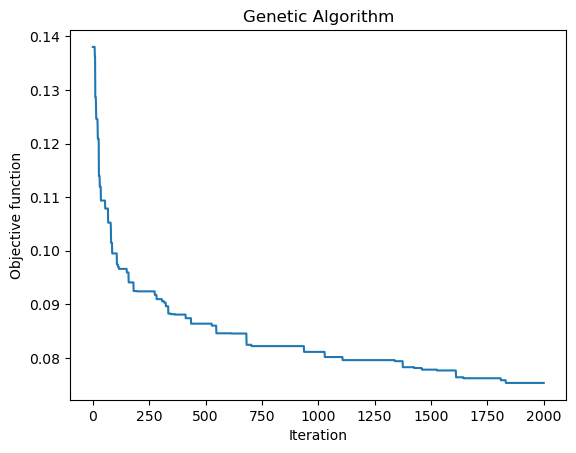

Selected Stocks: Int64Index([77338, 84563, 66093, 10220, 88924, 11955, 23393, 26825, 17750,
            87055, 56274, 92602, 65875, 48725, 39642, 90993, 52090, 63467,
            25320, 12052, 22111, 86228, 17942, 13721, 93089],
           dtype='int64', name='PERMNO')


In [15]:
# Run the genetic algorithm
model = ga(function=fitness_function, dimension=25, variable_type='int', variable_boundaries=varbound, algorithm_parameters=algo_params)
model.run()

# Get the optimal indices and selected stocks
optimal_indices = model.output_dict['variable']
selected_stocks = returns.columns[np.clip(np.round(optimal_indices), 0, len(returns.columns) - 1).astype(int)]

print(f"Selected Stocks: {selected_stocks}")

In [7]:
selected_stocks = [11308, 65875, 17778, 19393, 90601, 11308, 89006, 39642, 11955,
            17750, 13856, 22111, 23393, 89006, 14169, 17750, 11308, 55976,
            17144, 17144, 84563, 87055, 39642, 79133, 32870]

univ[(univ['PERMNO'].isin(selected_stocks)) & (univ['date'] == '2022-12-30')]

,PERMNO,date,SHRCD,EXCHCD,TICKER,COMNAM,PRC,RET,SHROUT,abs_PRC,year,quarter,marketCap,nTradingDays,marketCapRank
16156810,11308,2022-12-30,11.0,1.0,KO,COCA COLA CO,63.61000,-0.005317,4324513.0,63.61000,2022,4,2.750823e+08,251,25.0
16166058,11955,2022-12-30,11.0,1.0,WM,WASTE MANAGEMENT INC DEL,156.88000,-0.012526,410477.0,156.88000,2022,4,6.439563e+07,251,128.0
16202926,13856,2022-12-30,11.0,3.0,PEP,PEPSICO INC,180.66000,-0.007254,1377709.0,180.66000,2022,4,2.488969e+08,251,33.0
16213911,14169,2022-12-30,11.0,3.0,PINC,PREMIER INC,34.98000,0.000858,118762.0,34.98000,2022,4,4.154295e+06,251,988.0
16329363,17144,2022-12-30,11.0,1.0,GIS,GENERAL MILLS INC,83.85000,-0.006281,589611.0,83.85000,2022,4,4.943888e+07,251,181.0
16340927,17750,2022-12-30,11.0,1.0,KMB,KIMBERLY CLARK CORP,135.75000,-0.010857,337492.0,135.75000,2022,4,4.581454e+07,251,196.0
16341178,17778,2022-12-30,11.0,1.0,BRK,BERKSHIRE HATHAWAY INC DEL,468710.96875,-0.000030,597.0,468710.96875,2022,4,2.798204e+08,251,22.0
16410778,19393,2022-12-30,11.0,1.0,BMY,BRISTOL MYERS SQUIBB CO,71.95000,-0.002080,2126160.0,71.95000,2022,4,1.529772e+08,251,58.0
16552613,22111,2022-12-30,11.0,1.0,JNJ,JOHNSON & JOHNSON,176.64999,-0.005125,2614484.0,176.64999,2022,4,4.618486e+08,251,11.0
16570193,23393,2022-12-30,11.0,1.0,CHD,CHURCH & DWIGHT INC,80.61000,-0.011890,243868.0,80.61000,2022,4,1.965820e+07,251,346.0


In [31]:
univ[(univ['PERMNO']==32870)]

,PERMNO,date,SHRCD,EXCHCD,TICKER,COMNAM,PRC,RET,SHROUT,abs_PRC,year,quarter,marketCap,nTradingDays,marketCapRank
130400,32870,2000-01-03,11.0,1.0,HRL,HORMEL FOODS CORP,40.2500,-0.009231,71327.0,40.2500,2000,1,2.870912e+06,252,825.0
130401,32870,2000-01-04,11.0,1.0,HRL,HORMEL FOODS CORP,39.6875,-0.013975,71327.0,39.6875,2000,1,2.830790e+06,252,825.0
130402,32870,2000-01-05,11.0,1.0,HRL,HORMEL FOODS CORP,40.3125,0.015748,71327.0,40.3125,2000,1,2.875370e+06,252,825.0
130403,32870,2000-01-06,11.0,1.0,HRL,HORMEL FOODS CORP,41.0000,0.017054,71327.0,41.0000,2000,1,2.924407e+06,252,825.0
130404,32870,2000-01-07,11.0,1.0,HRL,HORMEL FOODS CORP,41.3750,0.009146,71327.0,41.3750,2000,1,2.951155e+06,252,825.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16588545,32870,2022-12-23,11.0,1.0,HRL,HORMEL FOODS CORP,45.6300,0.004845,546198.0,45.6300,2022,4,2.492301e+07,251,305.0
16588546,32870,2022-12-27,11.0,1.0,HRL,HORMEL FOODS CORP,45.8400,0.004602,546198.0,45.8400,2022,4,2.503772e+07,251,305.0
16588547,32870,2022-12-28,11.0,1.0,HRL,HORMEL FOODS CORP,45.3700,-0.010253,546198.0,45.3700,2022,4,2.478100e+07,251,305.0
16588548,32870,2022-12-29,11.0,1.0,HRL,HORMEL FOODS CORP,45.5100,0.003086,546198.0,45.5100,2022,4,2.485747e+07,251,305.0


In [ ]:
#65875 = Bell Atlantic Corp
#17778 = Berkshire Hathaway


In [16]:
selected_stocks = [77338, 84563, 66093, 10220, 88924, 11955, 23393, 26825, 17750,
            87055, 56274, 92602, 65875, 48725, 39642, 90993, 52090, 63467,
            25320, 12052, 22111, 86228, 17942, 13721, 93089]

univ[(univ['PERMNO'].isin(selected_stocks)) & (univ['date'] == '2022-12-30')]

,PERMNO,date,SHRCD,EXCHCD,TICKER,COMNAM,PRC,RET,SHROUT,abs_PRC,year,quarter,marketCap,nTradingDays,marketCapRank
16145689,10220,2022-12-30,11.0,1.0,BWXT,B W X TECHNOLOGIES INC,58.08000,0.002936,91222.0,58.08000,2022,4,5.298174e+06,251,902.0
16166058,11955,2022-12-30,11.0,1.0,WM,WASTE MANAGEMENT INC DEL,156.88000,-0.012526,410477.0,156.88000,2022,4,6.439563e+07,251,128.0
16167873,12052,2022-12-30,11.0,1.0,GD,GENERAL DYNAMICS CORP,248.11000,-0.004494,274549.0,248.11000,2022,4,6.811835e+07,251,137.0
16198779,13721,2022-12-30,11.0,1.0,ABBV,ABBVIE INC,161.61000,-0.005844,1768481.0,161.61000,2022,4,2.858042e+08,251,24.0
16340927,17750,2022-12-30,11.0,1.0,KMB,KIMBERLY CLARK CORP,135.75000,-0.010857,337492.0,135.75000,2022,4,4.581454e+07,251,196.0
16349284,17942,2022-12-30,11.0,3.0,KDP,KEURIG DR PEPPER INC,35.66000,-0.004745,1416251.0,35.66000,2022,4,5.050351e+07,251,164.0
16552613,22111,2022-12-30,11.0,1.0,JNJ,JOHNSON & JOHNSON,176.64999,-0.005125,2614484.0,176.64999,2022,4,4.618486e+08,251,11.0
16570193,23393,2022-12-30,11.0,1.0,CHD,CHURCH & DWIGHT INC,80.61000,-0.011890,243868.0,80.61000,2022,4,1.965820e+07,251,346.0
16577221,25320,2022-12-30,11.0,1.0,CPB,CAMPBELL SOUP CO,56.75000,0.000705,299468.0,56.75000,2022,4,1.699481e+07,251,455.0
16580484,26825,2022-12-30,11.0,1.0,K,KELLOGG CO,71.24000,-0.003218,341281.0,71.24000,2022,4,2.431286e+07,251,343.0
